In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.stats import wasserstein_distance
from statsmodels.distributions.empirical_distribution import ECDF
import datetime

import json

#Avoiding Type 3 fonts in matplotlib plots
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
font = {'size'   : 20}

matplotlib.rc('font', **font)
matplotlib.rc('lines', linewidth=2.0)
matplotlib.rc('lines', markersize=8)

In [3]:
res='results/'

### MiD data
mobilität in deutschland

In [4]:
# data reading
'''
wegkm: wegelänge, path length
hvm: hauptverkehrsmittel, main mode of transport
hvm_diff2: hauptverkehrsmittel (stärker differenziert), more differentiated

'''
df_MiD=pd.read_csv('data/MiD2017_Wege.csv',decimal=',',sep=';',usecols=['wegkm','hvm','hvm_diff2'])

#exclude unwanted lines with "unknown" distance value et al
df_MiD=df_MiD[df_MiD.wegkm.isin([9994,9999,70703]) == False]
df_MiD

,wegkm,hvm,hvm_diff2
0,21.85,4,9
1,0.39,1,1
2,21.85,4,9
3,2.45,1,1
4,2.45,1,1
...,...,...,...
960614,0.98,2,2
960615,0.98,2,2
960616,0.98,2,2
960617,18.00,5,16


In [25]:
# df_MiD[df_MiD.hvm.isin([5]) == True].hvm_diff2.unique()

array([16, 15, 13, 14, 20, 24, 22, 11, 21, 23, 19, 12])

In [5]:
df_MiD_walk =df_MiD[df_MiD.hvm.isin([1]) == True] # Walk
df_MiD_bike = df_MiD[df_MiD.hvm.isin([2]) == True] # Bicycle (incl. Ebike)
df_MiD_autopass = df_MiD[df_MiD.hvm.isin([3]) == True] # Auto Passengers
df_MiD_autodriver = df_MiD[df_MiD.hvm.isin([4]) == True] # Auto Drivers

df_MiD_public=df_MiD[df_MiD.hvm.isin([5]) == True] #public
# Public Transport w/o long distance vehicles,short range
df_MiD_SRpublic=df_MiD_public[df_MiD_public.hvm_diff2.isin([19,20,21,22,23])==False] 
# long range
df_MiD_LRpublic=df_MiD_public[df_MiD_public.hvm_diff2.isin([19,20,21,22])==True] 

In [8]:
def ccdf_draw(datalist,labels):
    fig, ax = plt.subplots(figsize=(10,8))
    for i,data in enumerate(datalist):
        sorted_data = np.sort(data)
        linspaced = np.linspace(0, 1, len(data), endpoint=False)
#         print(np.interp(3, sorted_data,linspaced))
        
        ax.plot(sorted_data, 1-linspaced, 'o-',label=labels[i],rasterized=False,markersize=3)
    plt.xlabel('Trip Length (km)')
    plt.ylabel('CCDF')
    plt.legend()
    plt.yscale("log")
    plt.xscale("log")
#     plt.ylim(1e-04,1e+0)  # untere+obere grenze von y
    plt.xlim(left=1e-0)  # untere+obere grenze von x
    plt.grid()
#     plt.show()
#     plt.ylim((0,1))
    plt.tight_layout()
    plt.savefig(res+'CCDF in MiD2017.pdf', dpi=100, bbox_inches='tight')


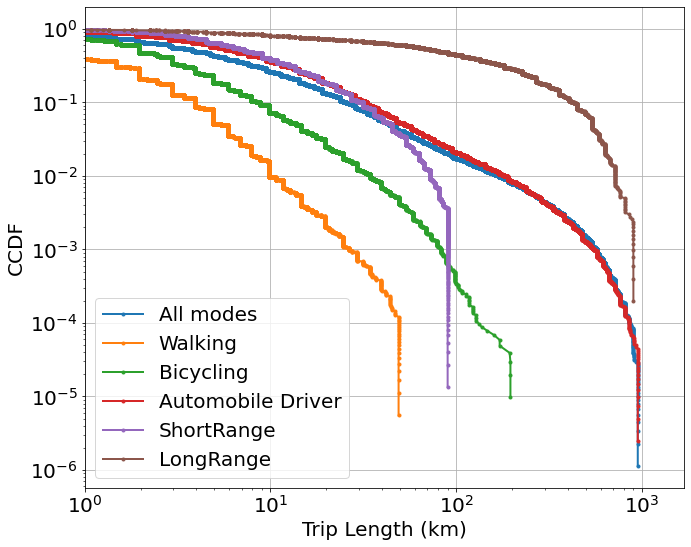

In [9]:
df_MiD_total=pd.concat([df_MiD_walk,df_MiD_bike,df_MiD_autopass,df_MiD_autodriver,df_MiD_public])
datalist=[df_MiD_total['wegkm'],df_MiD_walk['wegkm'],df_MiD_bike['wegkm'],df_MiD_autodriver['wegkm'],df_MiD_SRpublic['wegkm'],df_MiD_LRpublic['wegkm']]
labels=['All modes','Walking','Bicycling','Automobile Driver','ShortRange','LongRange']
ccdf_draw(datalist,labels)

### NHTS17 data
Travel behavior of the American public

In [6]:
# data reading

df_Nhts=pd.read_csv('data/trippub.csv',decimal='.',sep=',',usecols=["TRPMILES", "TRPTRANS","WHYTRP1S"])

df_Nhts.head(10)

,TRPMILES,TRPTRANS,WHYTRP1S
0,5.244,3,20
1,5.149,3,1
2,84.004,6,1
3,81.628,6,10
4,2.250,3,20
5,2.243,3,1
6,8.017,6,10
7,8.017,6,1
8,3.395,4,50
9,3.395,4,1


In [5]:
df_Nhts.shape

(923572, 3)

In [7]:
df_Nhts_walk =df_Nhts['TRPMILES'][df_Nhts.TRPTRANS.isin([1]) == True]*1.60934 # Walk and transform to km
df_Nhts_bike = df_Nhts['TRPMILES'][df_Nhts.TRPTRANS.isin([2]) == True]*1.60934 # Bicycle and transform to km
#3auto 4suv 5van 6rentalcar
df_Nhts_auto=df_Nhts['TRPMILES'][df_Nhts.TRPTRANS.isin([3,4,5,18])==True]*1.60934   #Auto
# Public Transport short range
#10school bus, 11public bus, 12paratransit / dial-a-ride, 13private/charter/tour/shutnhtse bus, 15amtrack / commuter rail, 16subway, 17taxi /limo (incl uber)
df_Nhts_SRpublic=df_Nhts['TRPMILES'][df_Nhts.TRPTRANS.isin([10,11,12,13,15,16,17])==True]*1.60934  
# long range
#14City-to-city bus (Greyhound, Megabus), 19Airplane, 20Boat/ferry/water taxi
df_Nhts_LRpublic=df_Nhts['TRPMILES'][df_Nhts.TRPTRANS.isin([14,19,20])==True]*1.60934  
df_Nhts_total=pd.concat([df_Nhts_walk,df_Nhts_bike,df_Nhts_auto,df_Nhts_SRpublic,df_Nhts_LRpublic])

In [20]:
def ccdf_draw(datalist,labels):
    fig, ax = plt.subplots(figsize=(10,8))
    for i,data in enumerate(datalist):
        sorted_data = np.sort(data)
        linspaced = np.linspace(0, 1, len(data), endpoint=False)
#         print(np.interp(3, sorted_data,linspaced))
        
        ax.plot(sorted_data, 1-linspaced, 'o-',label=labels[i],rasterized=False,markersize=3)
    plt.xlabel('Trip Length (km)')
    plt.ylabel('CCDF')
    plt.legend()
    plt.yscale("log")
    plt.xscale("log")
#     plt.ylim(1e-04,1e+0),  # untere+obere grenze von y
    plt.xlim(left=1e-0)  # untere+obere grenze von x
    plt.grid()
#     plt.show()
#     plt.ylim((0,1))
    plt.tight_layout()
    plt.savefig(res+'CCDF in NHTS.pdf', dpi=100, bbox_inches='tight')


<ipython-input-12-28cf7af51e0a>:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


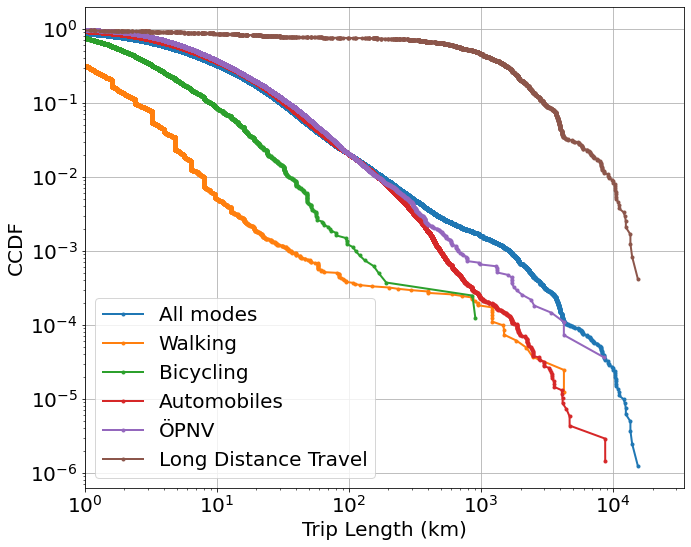

In [13]:
datalist=[df_Nhts_total,df_Nhts_walk,df_Nhts_bike,df_Nhts_auto,df_Nhts_SRpublic,df_Nhts_LRpublic]
labels=['All modes','Walking','Bicycling','Automobiles','Short Range','Long Distance']
ccdf_draw(datalist,labels)

## Modelling

In [85]:
# df_vec=df_MiD_autodriver['wegkm'].copy() # Auto Driver in MiD 2017
# df_vec=df_MiD_SRpublic['wegkm'].copy() #Short range public in MiD 2017
# df_vec=df_MiD_bike['wegkm'].copy() # bike in MiD 2017

# df_vec=df_Nhts_auto.copy() #Auto Driver in Nhts 17
df_vec=df_Nhts_SRpublic.copy() #Short range public in Nhts17
# df_vec=df_Nhts_bike.copy() # bike in Nhts17

#number of trips to be generated for each parameter combination. high influence on calculation time!
sampleNumber_model=10000
sampleNumber_visualization=10000

#trip lengths at which the difference between df_vec and model output is determined and summed up
# messpt=[1, 3, 5.5, 10, 30, 55, 100, 300] # for autodriver in MiD 2017
# messpt=[1, 3, 10, 30, 55,75] # for short range public in MiD 2017 since the max length in this dataset smaller than 100
# messpt=[ 1,3,5,7,10,30,55,70,100,150] # for bike in MiD 2017

# messpt=[ 10, 55, 100, 300,700,1000,5000,7000] # for auto and short range in nhts 17
# messpt=[ 1,3,5,7,10, 30, 55, 70,100, 300,500,700,1000,3000,5000,7000] # for auto and short range in nhts 17------NEW
# messpt=[ 1,3,5,7,10,30,55,70,100,200] # for bike in nhts 17

# select the data between 10km and 1000km
df_vec=df_vec[df_vec.between(10,1000)]
# df_vec=df_vec[df_vec>=10]
df_vec.shape

(10223,)

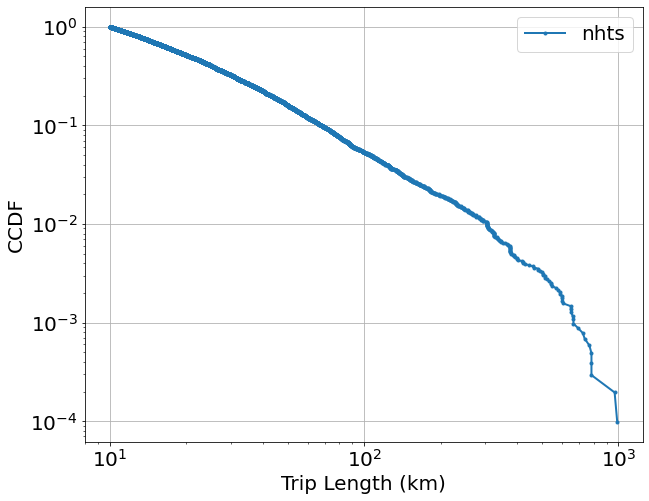

In [66]:
fig, ax = plt.subplots(figsize=(10,8))
for i,data in enumerate([df_vec]):
    sorted_data = np.sort(data)
    linspaced = np.linspace(0, 1, len(data), endpoint=False)
#         print(np.interp(3, sorted_data,linspaced))

    ax.plot(sorted_data, 1-linspaced, 'o-',label='nhts',rasterized=False,markersize=3)
plt.xlabel('Trip Length (km)')
plt.ylabel('CCDF')
plt.legend()
plt.yscale("log")
plt.xscale("log")

# plt.xlim(left=1e-0)  # untere+obere grenze von x
plt.grid()
plt.show()

In [86]:
#definition
# eps_range=np.arange(0.1,2,0.05)
# p_range=np.arange(0.1, 0.95, 0.05)#0.05

# eps_range=np.arange(0.1,2,0.03)# ----new for nhts
# # p_range=np.arange(0.01, 0.95, 0.03)#0.05 ----new for nhts
# p_range=np.arange(0, 0.95, 0.03)#0.05 ----new for nhts
# alp_range=np.arange(1.1, 2.5,0.05)#0.05


# refine the best fit params
eps_range=np.arange(0.75,0.95,0.01)# ----new for nhts
p_range=np.arange(0.35, 0.45, 0.01)#0.05 ----new for nhts
alp_range=np.arange(2.3, 2.7,0.05)#0.05

err=[0]
combinable=[[eps,p,alp,0] for eps in eps_range for p in p_range for alp in alp_range for error in err] #list
for i in range(2):
    print (combinable[i])
print(len(eps_range)*len(p_range)*len(alp_range))

[0.75, 0.35, 2.3, 0]
[0.75, 0.35, 2.3499999999999996, 0]
1980


In [87]:
%%time

for i in range(len(combinable)):
    if i%300==0:
        print(i)
        print ("Current date and time : ",datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    eps=combinable[i][0]
    p=combinable[i][1]
    alp=combinable[i][2]
    error=combinable[i][3]
    dist=[]
    for n in range(sampleNumber_model):
        distance=9999999
        # 1000 for MiD dataset
        #while(distance>=1000):
        #distance > 10000 for nhts dataset
        while(distance>=1000 or distance<10):
            # np.random.uniform(0,1,1) generates one uniform random number between 0 and 1.
            # let sp be drawn from pow(alpha)
            sp=np.random.uniform(0,1,1)**(-1/(alp-1))
            random=np.random.uniform(0,1,1)
            distance=sp[0]
            while (random<p):
                distance=(1+eps)*distance
                random=np.random.uniform(0,1,1)
        dist.append(distance)
      
    
    # method 1 to compute the error
#     for e in messpt:
# #         print(ECDF(dist)(e))
# #         print(ECDF(df_vec)(e))
# #         print(1-ECDF(df_vec)(e))
# #         print(e,'------')
#         error=error+((((ECDF(dist)(e)-ECDF(df_vec)(e))**2)**0.5)/(1-ECDF(df_vec)(e)))
    
    # method 2 to compute the error
    # wasserstein_distance
    error=wasserstein_distance(dist,df_vec)
    combinable[i][3]=error

0
Current date and time :  2022-12-13 11:51:03
300
Current date and time :  2022-12-13 12:04:06
600
Current date and time :  2022-12-13 12:16:27
900
Current date and time :  2022-12-13 12:28:34
1200
Current date and time :  2022-12-13 12:40:16
1500
Current date and time :  2022-12-13 12:51:34
1800
Current date and time :  2022-12-13 13:02:35
CPU times: user 1h 17min 9s, sys: 31.8 s, total: 1h 17min 41s
Wall time: 1h 17min 51s


In [88]:
# Convert to df and save
df_com=pd.DataFrame(combinable)

# df_com.to_pickle(res+'model paras of AutoDriver in MiD17.pkl')
# df_com=pd.read_pickle(res+'model paras of AutoDriver in MiD17.pkl')

# df_com.to_pickle(res+'model paras of ShortRange in MiD17.pkl')
#read and convert back
# df_com=pd.read_pickle(res+'model paras of ShortRange in MiD17.pkl')

# df_com.to_pickle(res+'model paras of Bike in MiD17.pkl')
# df_com=pd.read_pickle(res+'model paras of Bike in MiD17.pkl')


# df_com.to_pickle(res+'model paras of AutoDriver in Nhts17.pkl')
# df_com=pd.read_pickle(res+'model paras of AutoDriver in Nhts17.pkl')

# df_com.to_pickle(res+'model paras of ShortRange in Nhts17_new params.pkl')
# df_com=pd.read_pickle(res+'model paras of ShortRange in Nhts17.pkl')

df_com.to_pickle(res+'model paras of ShortRange in Nhts17_new params_new error_new P_simulate_between10and1000km.pkl')
# df_com.to_pickle(res+'model paras of ShortRange in Nhts17_new params_new error_new P_over10km.pkl')
# df_com.to_pickle(res+'model paras of ShortRange in Nhts17_new params_new error_new P.pkl')
# df_com.to_pickle(res+'model paras of ShortRange in Nhts17_new params_new error.pkl')
# df_com=pd.read_pickle(res+'model paras of ShortRange in Nhts17.pkl')

# df_com.to_pickle(res+'model paras of Bike in Nhts17.pkl')
# df_com=pd.read_pickle(res+'model paras of Bike in Nhts17.pkl')
combinable=df_com.values.tolist()

In [89]:
'''distance vector generation
input:
    eps
    p
    alpha
    
output:
    dist: distance vector
'''
def dist_vec_gen(sampleNumber_visualization,eps,p,alp):
    
    dist=[]
    for n in range(sampleNumber_visualization):
        distance=9999999
#         while(distance>=1000):
        while(distance>=1000 or distance <10): #for nhts17 dataset
#         while(distance>=200): #for mid dataset: bike
            # np.random.uniform(0,1,1) generates one uniform random number between 0 and 1.
            # let sp be drawn from pow(alpha)
            sp=np.random.uniform(0,1,1)**(-1/(alp-1))
            random=np.random.uniform(0,1,1)
            distance=sp[0]
            while (random<p):
                distance=(1+eps)*distance
                random=np.random.uniform(0,1,1)
        dist.append(distance)
    return dist


In [90]:
#line 0 auto driver

#line 1 handpicked
eps1=2
p1=0.7
alp1=1.1
dist1= dist_vec_gen(sampleNumber_visualization,eps1,p1,alp1)


# convert to numpy array
com=np.array(combinable)
print(com.shape)

#line 2 best fit
# which error is the lowest
idx_best=com[:,3].argmin()
eps2 = com[idx_best,0]
p2 = com[idx_best,1]
alp2 = com[idx_best,2]
dist2= dist_vec_gen(sampleNumber_visualization,eps2,p2,alp2)

#line 3 worst fit
idx_worst=com[:,3].argmax()
eps3 = com[idx_worst,0]
p3 = com[idx_worst,1]
alp3 = com[idx_worst,2]
dist3= dist_vec_gen(sampleNumber_visualization,eps3,p3,alp3)

(1980, 4)


In [247]:
# autodriver in MiD 2017
print(com[:,3].min(),com[:,3].max())
print(eps1,p1,alp1,eps2,p2,alp2,eps3,p3,alp3)

0.911323857533286 105.82166593731804
2 0.7 1.1 0.35000000000000003 0.7500000000000002 2.100000000000001 1.3 0.9000000000000002 1.1


In [256]:
# Short range public in MiD 2017
print(com[:,3].min(),com[:,3].max())
print(eps1,p1,alp1,eps2,p2,alp2,eps3,p3,alp3)

1.5058163562686924 94.0877277719395
2 0.7 1.1 0.15000000000000002 0.7000000000000002 1.9500000000000008 1.6 0.9000000000000002 1.1


In [305]:
#Bike MiD2017
print(com[:,3].min(),com[:,3].max())
print(eps1,p1,alp1,eps2,p2,alp2,eps3,p3,alp3)

3.288817073050719 2794.392094461695
2 0.7 1.1 0.8 0.20000000000000004 2.250000000000001 1.1500000000000001 0.8500000000000002 1.1


In [270]:
# autodriver in Nhts17
print(com[:,3].min(),com[:,3].max())
print(eps1,p1,alp1,eps2,p2,alp2,eps3,p3,alp3)

4.735972294671592 79207.5322810473
2 0.7 1.1 0.2 0.1 1.7000000000000006 1.55 0.9000000000000002 1.1500000000000001


In [279]:
#short range Nhts17
print(com[:,3].min(),com[:,3].max())
print(eps1,p1,alp1,eps2,p2,alp2,eps3,p3,alp3)

4.626965372099182 6814.1343928215965
2 0.7 1.1 0.05 0.9000000000000002 1.8500000000000008 1.1 0.9000000000000002 1.1


In [44]:
#short range Nhts17---new params
print(com[:,3].min(),com[:,3].max())
print(eps1,p1,alp1,eps2,p2,alp2,eps3,p3,alp3)

7.13150404698985 8828.427163972436
2 0.7 1.1 1.6 0.45999999999999996 2.250000000000001 0.85 0.94 1.1500000000000001


In [55]:
#short range Nhts17---new params---new error method
print(com[:,3].min(),com[:,3].max())
print(eps1,p1,alp1,eps2,p2,alp2,eps3,p3,alp3)

4.454465769303726 1698.783816378225
2 0.7 1.1 0.4 0.6699999999999999 2.1500000000000012 0.7899999999999999 0.94 1.1


In [13]:
#short range Nhts17---new params---new error method---p can be 0
print(com[:,3].min(),com[:,3].max())
print(eps1,p1,alp1,eps2,p2,alp2,eps3,p3,alp3)

4.7520321181153875 1662.7523100247206
2 0.7 1.1 0.25 0.8099999999999999 2.200000000000001 1.81 0.8999999999999999 1.1


In [19]:
#short range Nhts17---new params---new error method---p can be 0---over 10km
print(com[:,3].min(),com[:,3].max())
print(eps1,p1,alp1,eps2,p2,alp2,eps3,p3,alp3)

18.507777898700443 1659.0998960077702
2 0.7 1.1 0.94 0.6 2.200000000000001 1.99 0.9299999999999999 1.1


In [34]:
#short range Nhts17---new params---new error method---p can be 0---simulate_over 10km
print(com[:,3].min(),com[:,3].max())
print(eps1,p1,alp1,eps2,p2,alp2,eps3,p3,alp3)

4.688603224779429 1923.568854148891
2 0.7 1.1 0.9099999999999999 0.42 2.4000000000000012 1.93 0.9299999999999999 1.1


In [45]:
#short range Nhts17---new params---new error method---p can be 0---simulate_over 10km
print(com[:,3].min(),com[:,3].max())
print(eps1,p1,alp1,eps2,p2,alp2,eps3,p3,alp3)

4.688603224779429 1923.568854148891
2 0.7 1.1 0.9099999999999999 0.42 2.4000000000000012 1.93 0.9299999999999999 1.1


In [74]:
#short range Nhts17---new params---new error method---p can be 0---simulate_over between 10-1000km #samples2000
print(com[:,3].min(),com[:,3].max())
print(eps1,p1,alp1,eps2,p2,alp2,eps3,p3,alp3)

2.1135655984394757 9.724983552616898
2 0.7 1.1 0.89 0.4 2.4499999999999997 0.86 0.36 2.699999999999999


In [82]:
#short range Nhts17---new params---new error method---p can be 0---simulate_over between 10-1000km #samples10000
print(com[:,3].min(),com[:,3].max())
print(eps1,p1,alp1,eps2,p2,alp2,eps3,p3,alp3)

2.5846170337106087 8.766310430297988
2 0.7 1.1 0.85 0.4 2.4499999999999997 0.86 0.35 2.699999999999999


In [91]:
#short range Nhts17---new params---new error method---p can be 0---simulate_over between 10-1000km #samples10000
print(com[:,3].min(),com[:,3].max())
print(eps1,p1,alp1,eps2,p2,alp2,eps3,p3,alp3)

2.4541859191288786 10.456599131567252
2 0.7 1.1 0.8800000000000001 0.44000000000000006 2.6999999999999984 0.75 0.35 2.6999999999999984


In [289]:
#Bike Nhts17
print(com[:,3].min(),com[:,3].max())
print(eps1,p1,alp1,eps2,p2,alp2,eps3,p3,alp3)

3.08572583406345 547.2482490075568
2 0.7 1.1 0.65 0.25000000000000006 2.100000000000001 1.9000000000000001 0.9000000000000002 1.1


In [92]:
def ccdf_draw(datalist,labels):
    fig, ax = plt.subplots(figsize=(10,8))
    for i,data in enumerate(datalist):
        sorted_data = np.sort(data)
        linspaced = np.linspace(0, 1, len(data), endpoint=False)
#         print(np.interp(3, sorted_data,linspaced))
        
        ax.plot(sorted_data, 1-linspaced, 'o-',label=labels[i],rasterized=False,markersize=3)
    plt.xlabel('Trip Length (km)')
    plt.ylabel('CCDF')
    plt.legend()
    plt.yscale("log")
    plt.xscale("log")
#     plt.ylim(1e-04,1e+0),  # untere+obere grenze von y
#     plt.xlim(1e-1,1e+3),  # untere+obere grenze von x
    plt.xlim(left=1e+1)
    plt.grid()
#     plt.show()
#     plt.ylim((0,1))
    plt.tight_layout()
#     plt.savefig(res+'CCDF of Modelling in MiD_AutoDriver.pdf', dpi=100, bbox_inches='tight')
#     plt.savefig(res+'CCDF of Modelling in MiD_ShortRange.pdf', dpi=100, bbox_inches='tight')
#     plt.savefig(res+'CCDF of Modelling in MiD_Bike.pdf', dpi=100, bbox_inches='tight')
#     plt.savefig(res+'CCDF of Modelling in Nhts_AutoDriver.pdf', dpi=100, bbox_inches='tight')
#     plt.savefig(res+'CCDF of Modelling in Nhts_ShortRange.pdf', dpi=100, bbox_inches='tight')
#     plt.savefig(res+'CCDF of Modelling in Nhts_ShortRange_new params.pdf', dpi=100, bbox_inches='tight')
#     plt.savefig(res+'CCDF of Modelling in Nhts_ShortRange_new params_new error_new p.pdf', dpi=100, bbox_inches='tight')
#     plt.savefig(res+'CCDF of Modelling in Nhts_ShortRange_new params_new error_new p_over 10km.pdf', dpi=100, bbox_inches='tight')
    plt.savefig(res+'CCDF of Modelling in Nhts_ShortRange_new params_new error_new P_simulate_between10and1000km.pdf', dpi=100, bbox_inches='tight')
#     plt.savefig(res+'CCDF of Modelling in Nhts_Bike.pdf', dpi=100, bbox_inches='tight')



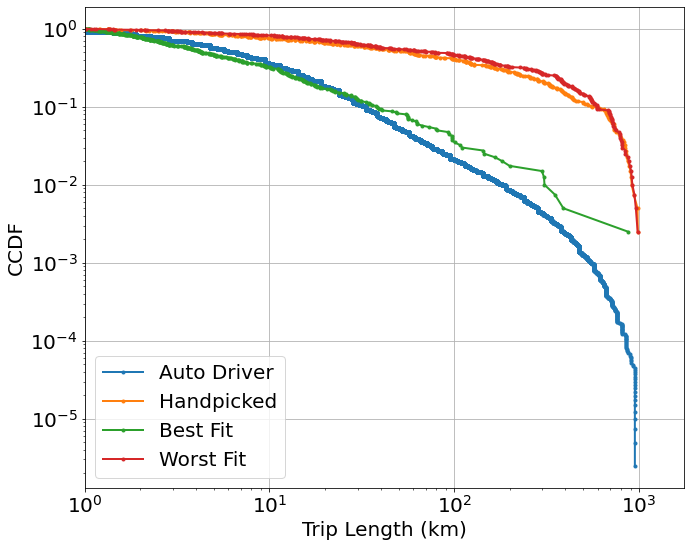

In [249]:
'''
MiD2017_AutoDriver
'''
datalist=[df_vec,dist1,dist2,dist3]
labels=['Auto Driver','Handpicked','Best Fit','Worst Fit']
ccdf_draw(datalist,labels)

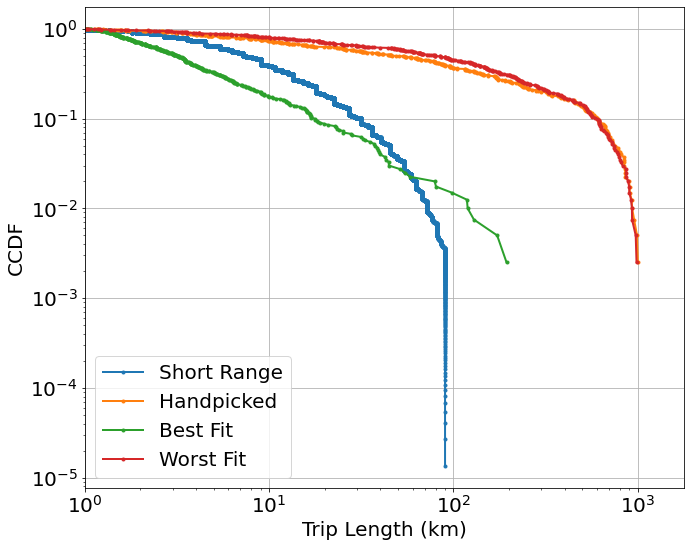

In [258]:
'''
MiD2017_ShortRange
'''
datalist=[df_vec,dist1,dist2,dist3]
labels=['Short Range','Handpicked','Best Fit','Worst Fit']
ccdf_draw(datalist,labels)

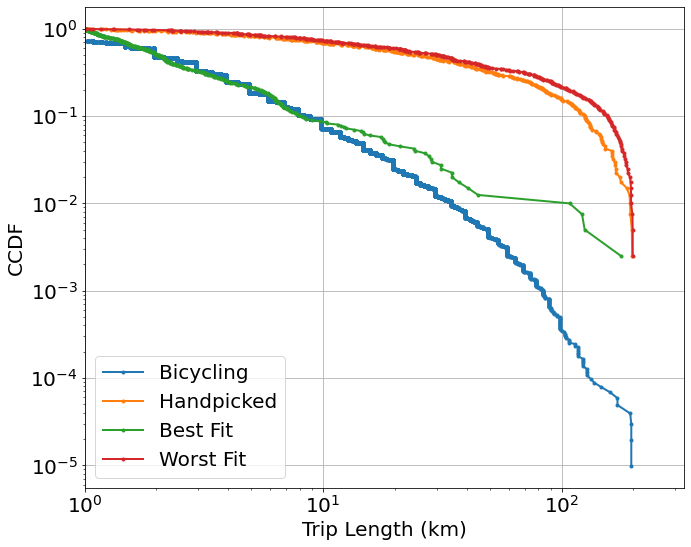

In [307]:
'''
MiD_Bike
'''
datalist=[df_vec,dist1,dist2,dist3]
labels=['Bicycling','Handpicked','Best Fit','Worst Fit']
ccdf_draw(datalist,labels)

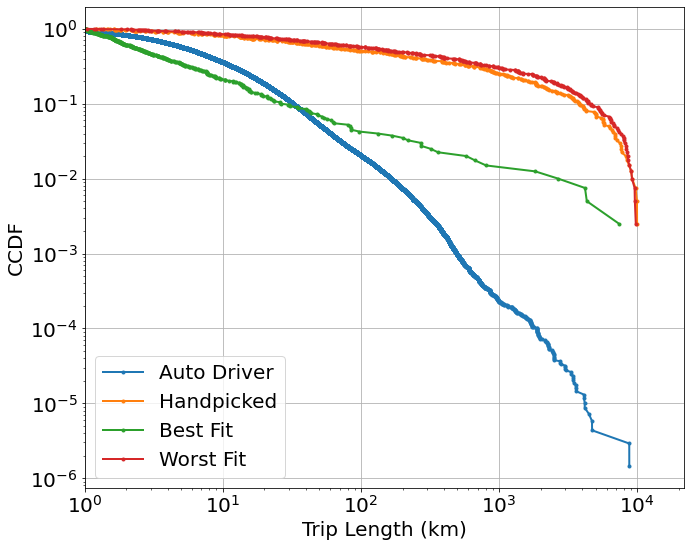

In [272]:
'''
Nhts17_AutoDriver
'''
datalist=[df_vec,dist1,dist2,dist3]
labels=['Auto Driver','Handpicked','Best Fit','Worst Fit']
ccdf_draw(datalist,labels)

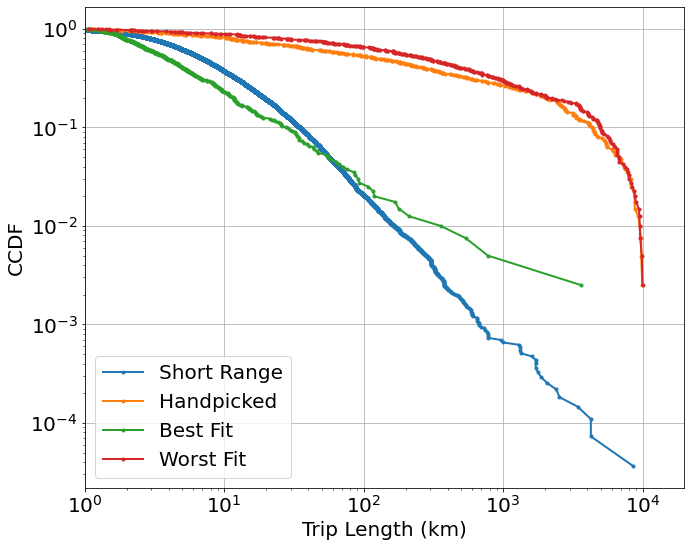

In [281]:
'''
Nhts17_ShortRange
'''
datalist=[df_vec,dist1,dist2,dist3]
labels=['Short Range','Handpicked','Best Fit','Worst Fit']
ccdf_draw(datalist,labels)

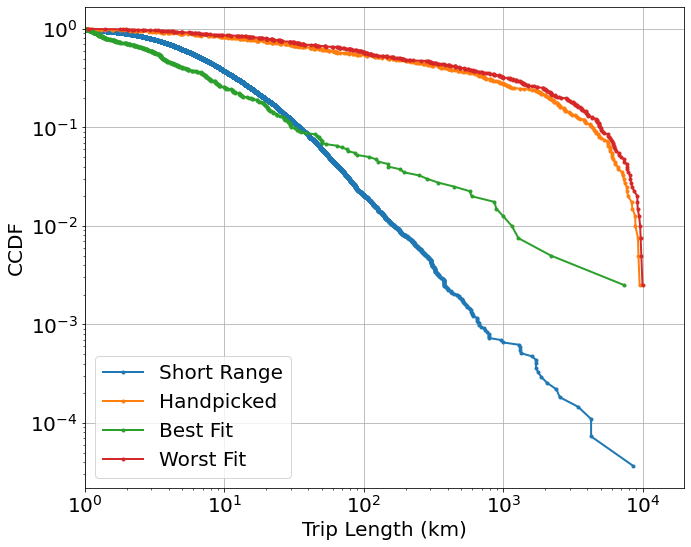

In [46]:
'''
Nhts17_ShortRange New params selected
'''
datalist=[df_vec,dist1,dist2,dist3]
labels=['Short Range','Handpicked','Best Fit','Worst Fit']
ccdf_draw(datalist,labels)

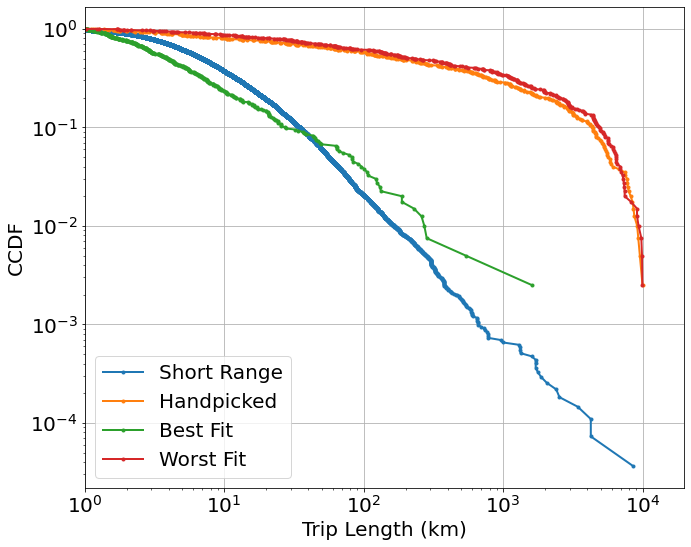

In [59]:
'''
Nhts17_ShortRange New params selected, new error method---wasserstein_distance
'''
datalist=[df_vec,dist1,dist2,dist3]
labels=['Short Range','Handpicked','Best Fit','Worst Fit']
ccdf_draw(datalist,labels)

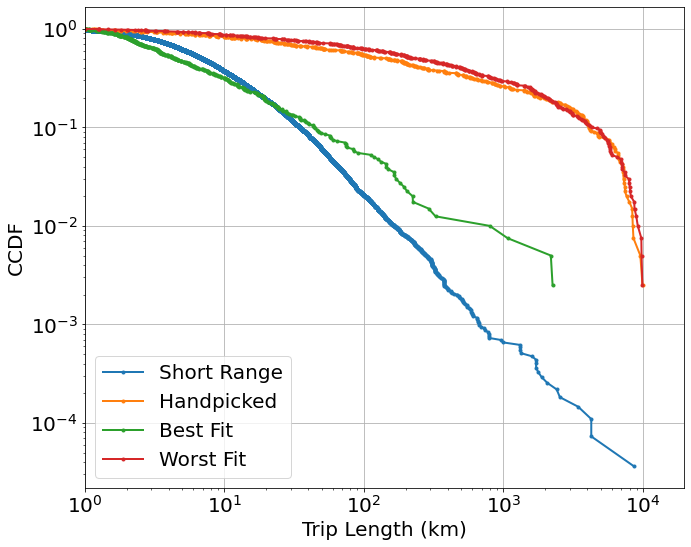

In [15]:
'''
Nhts17_ShortRange New params selected, new error method---wasserstein_distance
p can be 0
'''
datalist=[df_vec,dist1,dist2,dist3]
labels=['Short Range','Handpicked','Best Fit','Worst Fit']
ccdf_draw(datalist,labels)

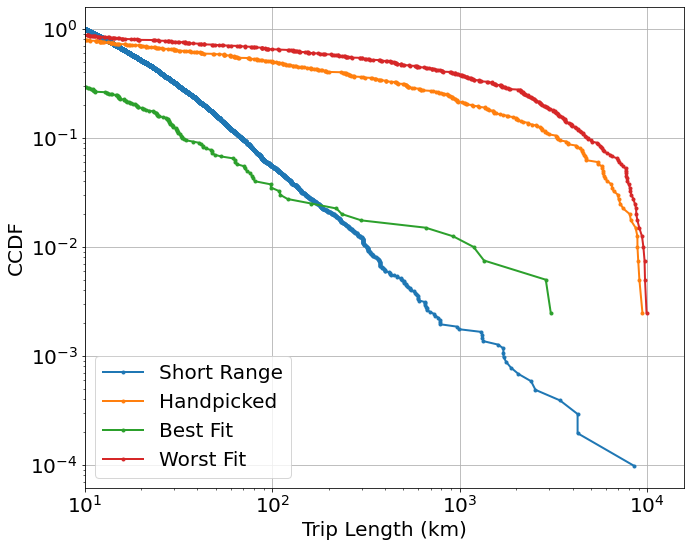

In [27]:
'''
Nhts17_ShortRange New params selected, new error method---wasserstein_distance
p can be 0---over 10km
'''
datalist=[df_vec,dist1,dist2,dist3]
labels=['Short Range','Handpicked','Best Fit','Worst Fit']
ccdf_draw(datalist,labels)

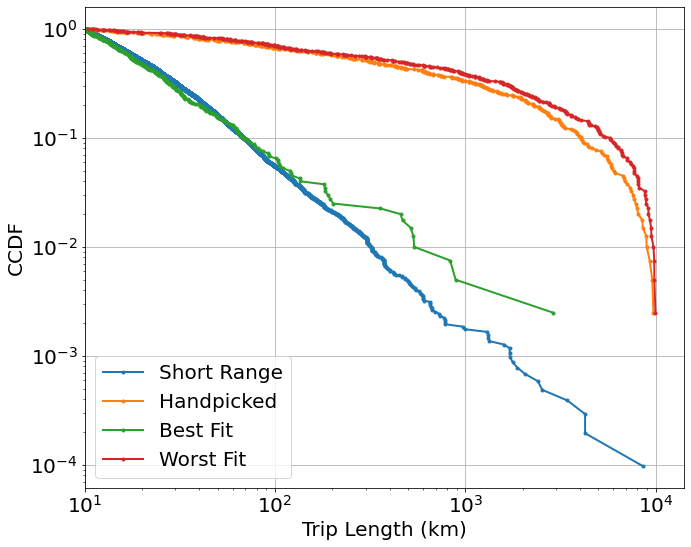

In [40]:
'''
Nhts17_ShortRange New params selected, new error method---wasserstein_distance
p can be 0---simulate_over 10km
'''
datalist=[df_vec,dist1,dist2,dist3]
labels=['Short Range','Handpicked','Best Fit','Worst Fit']
ccdf_draw(datalist,labels)

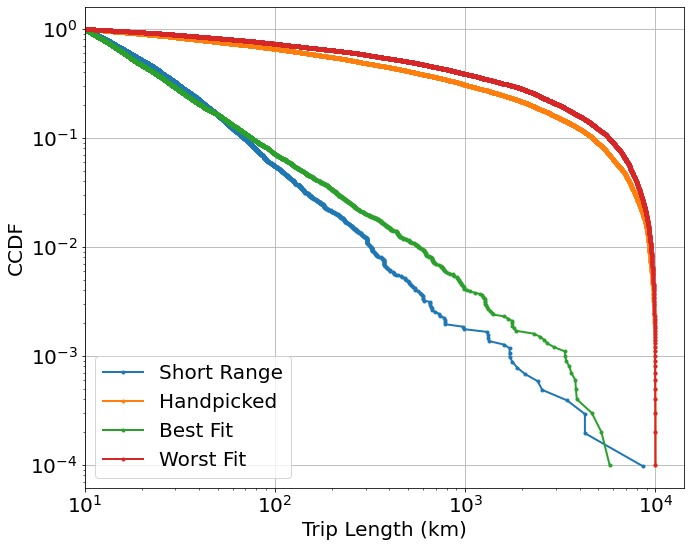

In [46]:
'''
Nhts17_ShortRange New params selected, new error method---wasserstein_distance
p can be 0---simulate_over 10km
'''
datalist=[df_vec,dist1,dist2,dist3]
labels=['Short Range','Handpicked','Best Fit','Worst Fit']
ccdf_draw(datalist,labels)

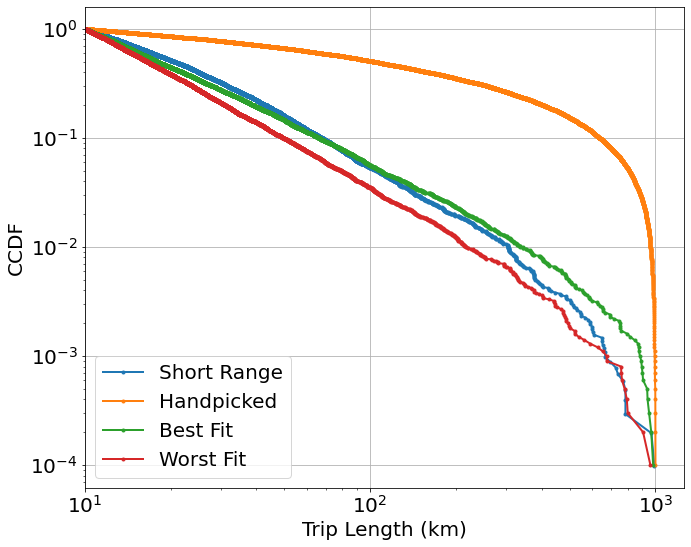

In [75]:
'''
Nhts17_ShortRange New params selected, new error method---wasserstein_distance
p can be 0---simulate_between 10-1000km
'''
datalist=[df_vec,dist1,dist2,dist3]
labels=['Short Range','Handpicked','Best Fit','Worst Fit']
ccdf_draw(datalist,labels)

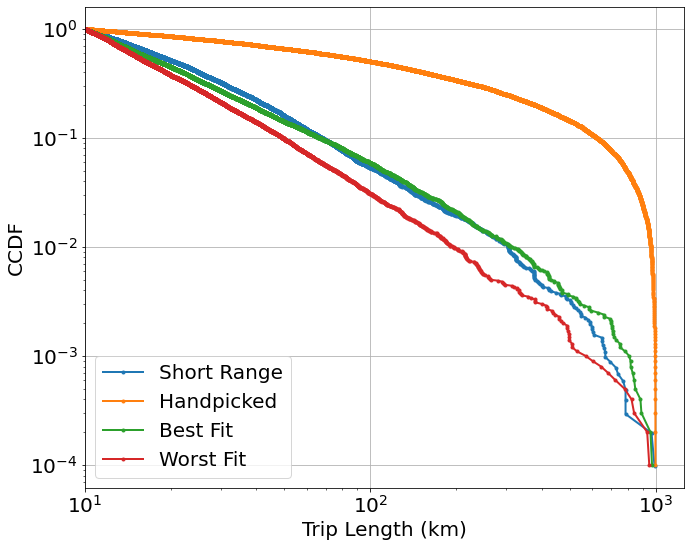

In [84]:
'''
Nhts17_ShortRange New params selected, new error method---wasserstein_distance
p can be 0---simulate_between 10-1000km #samples 10000
''' 
datalist=[df_vec,dist1,dist2,dist3]
labels=['Short Range','Handpicked','Best Fit','Worst Fit']
ccdf_draw(datalist,labels)

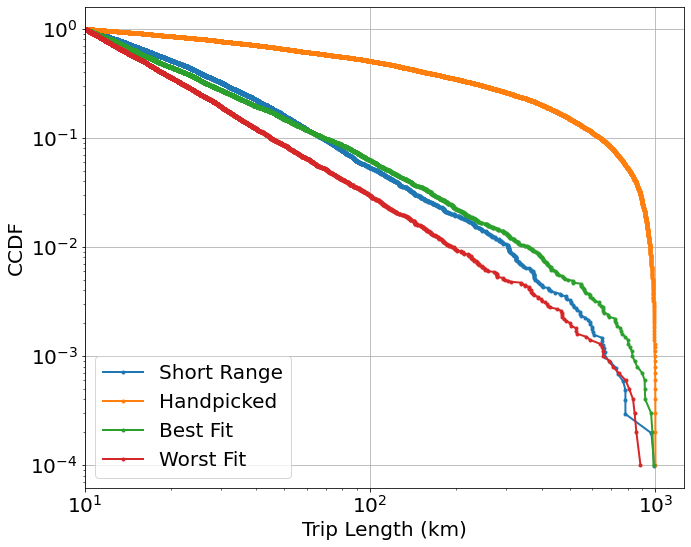

In [93]:
'''
Nhts17_ShortRange New params selected, new error method---wasserstein_distance
p can be 0---simulate_between 10-1000km #samples 10000
''' 
datalist=[df_vec,dist1,dist2,dist3]
labels=['Short Range','Handpicked','Best Fit','Worst Fit']
ccdf_draw(datalist,labels)

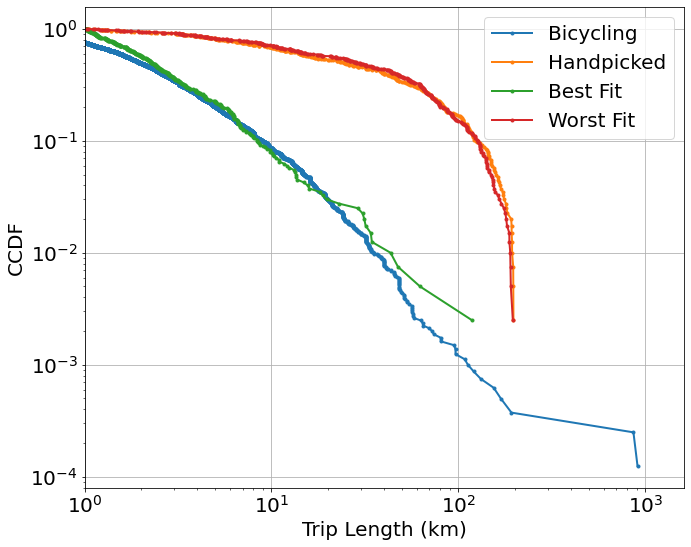

In [295]:
'''
Nhts17_Bike
'''
datalist=[df_vec,dist1,dist2,dist3]
labels=['Bicycling','Handpicked','Best Fit','Worst Fit']
ccdf_draw(datalist,labels)

## RKI Dataset

In [51]:
# data reading
'''
'''
df_7days_incidences=pd.read_csv('data/7-days incidences.csv')
df_7days_incidences
# #exclude unwanted lines with "unknown" distance value et al
# df_MiD=df_MiD[df_MiD.wegkm.isin([9994,9999,70703]) == False]
# df_MiD

,NR,LK,LKNR,18.11.2020,19.11.2020,20.11.2020,21.11.2020,22.11.2020,23.11.2020,24.11.2020,...,2021/9/1,2021/9/2,2021/9/3,2021/9/4,2021/9/5,2021/9/6,2021/9/7,2021/9/8,2021/9/9,2021/9/10
0,2,LK Ahrweiler,7131,143.8,156.1,159.1,156.1,172.2,139.1,139.9,...,122.7,148.8,188.0,177.0,199.3,183.4,197.2,208.7,171.8,191.8
1,3,LK Aichach-Friedberg,9771,144.8,138.9,158.2,173.8,167.8,156.0,139.6,...,68.9,90.4,98.6,102.2,99.2,92.7,92.7,94.9,68.2,71.2
2,4,LK Alb-Donau-Kreis,8425,114.7,117.2,123.8,124.8,121.8,122.8,118.2,...,70.3,88.5,95.5,107.0,89.3,104.6,103.1,91.0,84.4,78.9
3,5,LK Altenburger Land,16077,145.4,153.3,129.8,205.8,212.5,200.2,219.3,...,21.4,22.5,30.4,28.3,27.2,27.1,27.1,44.0,40.6,36.1
4,6,LK Altenkirchen,7132,63.7,58.2,66.8,90.1,97.8,104.8,104.8,...,91.5,103.9,106.2,113.9,104.6,103.1,117.1,114.0,98.5,98.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,407,SK Wuppertal,5124,189.2,193.7,176.9,203.9,198.3,198.3,194.9,...,266.2,252.1,246.2,240.0,227.6,220.8,215.5,214.9,208.4,210.4
408,408,SK Würzburg,9663,104.7,97.7,96.1,100.1,83.6,74.3,91.5,...,95.1,99.0,106.1,99.2,89.0,98.2,96.6,98.2,99.8,96.6
409,411,SK Zweibrücken,7320,93.6,99.4,90.7,96.5,73.1,46.8,64.3,...,49.9,67.5,88.1,94.1,97.1,96.9,99.8,102.7,88.1,64.6
410,1,StadtRegion Aachen,5334,211.8,179.3,174.3,161.4,121.2,116.0,149.4,...,85.0,83.3,83.0,76.0,81.6,82.3,82.1,66.6,73.6,69.7


In [52]:
# reading json file which contains coordinate info
f=open('data/ags.json')
gis=json.load(f)
gis

{'1001': {'name': 'SK Flensburg',
  'state': 'Schleswig-Holstein',
  'lat': 54.7805,
  'lon': 9.4352,
  'population': 90164},
 '1002': {'name': 'SK Kiel',
  'state': 'Schleswig-Holstein',
  'lat': 54.3227,
  'lon': 10.1359,
  'population': 246794},
 '1003': {'name': 'SK Lübeck',
  'state': 'Schleswig-Holstein',
  'lat': 53.8696,
  'lon': 10.6876,
  'population': 216530},
 '1004': {'name': 'SK Neumünster',
  'state': 'Schleswig-Holstein',
  'lat': 54.074,
  'lon': 9.9845,
  'population': 80196},
 '1051': {'name': 'LK Dithmarschen',
  'state': 'Schleswig-Holstein',
  'lat': 54.1474,
  'lon': 9.1114,
  'population': 133193},
 '1053': {'name': 'LK Herzogtum Lauenburg',
  'state': 'Schleswig-Holstein',
  'lat': 53.6013,
  'lon': 10.5866,
  'population': 198019},
 '1054': {'name': 'LK Nordfriesland',
  'state': 'Schleswig-Holstein',
  'lat': 54.6354,
  'lon': 8.7241,
  'population': 165951},
 '1055': {'name': 'LK Ostholstein',
  'state': 'Schleswig-Holstein',
  'lat': 54.1767,
  'lon': 10.84

In [53]:
# mapping the latitude and longitude
for k in df_7days_incidences['LK']:
    idx=df_7days_incidences['LK'][df_7days_incidences['LK']==k].index[0]
    
    for new_k in gis.items():
        if new_k[1]['name']==k:
            df_7days_incidences.at[idx,'lat']=new_k[1]['lat']
            df_7days_incidences.at[idx,'lon']=new_k[1]['lon']
            df_7days_incidences.at[idx,'state']=new_k[1]['state']
            break


In [54]:
df_7days_incidences

,NR,LK,LKNR,18.11.2020,19.11.2020,20.11.2020,21.11.2020,22.11.2020,23.11.2020,24.11.2020,...,2021/9/4,2021/9/5,2021/9/6,2021/9/7,2021/9/8,2021/9/9,2021/9/10,lat,lon,state
0,2,LK Ahrweiler,7131,143.8,156.1,159.1,156.1,172.2,139.1,139.9,...,177.0,199.3,183.4,197.2,208.7,171.8,191.8,50.4365,7.0050,Rheinland-Pfalz
1,3,LK Aichach-Friedberg,9771,144.8,138.9,158.2,173.8,167.8,156.0,139.6,...,102.2,99.2,92.7,92.7,94.9,68.2,71.2,48.4111,11.0451,Bayern
2,4,LK Alb-Donau-Kreis,8425,114.7,117.2,123.8,124.8,121.8,122.8,118.2,...,107.0,89.3,104.6,103.1,91.0,84.4,78.9,48.4011,9.8363,Baden-Württemberg
3,5,LK Altenburger Land,16077,145.4,153.3,129.8,205.8,212.5,200.2,219.3,...,28.3,27.2,27.1,27.1,44.0,40.6,36.1,50.9579,12.3802,Thüringen
4,6,LK Altenkirchen,7132,63.7,58.2,66.8,90.1,97.8,104.8,104.8,...,113.9,104.6,103.1,117.1,114.0,98.5,98.5,50.7127,7.6828,Rheinland-Pfalz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,407,SK Wuppertal,5124,189.2,193.7,176.9,203.9,198.3,198.3,194.9,...,240.0,227.6,220.8,215.5,214.9,208.4,210.4,51.2613,7.1630,Nordrhein-Westfalen
408,408,SK Würzburg,9663,104.7,97.7,96.1,100.1,83.6,74.3,91.5,...,99.2,89.0,98.2,96.6,98.2,99.8,96.6,49.7878,9.9361,Bayern
409,411,SK Zweibrücken,7320,93.6,99.4,90.7,96.5,73.1,46.8,64.3,...,94.1,97.1,96.9,99.8,102.7,88.1,64.6,49.2500,7.3667,Rheinland-Pfalz
410,1,StadtRegion Aachen,5334,211.8,179.3,174.3,161.4,121.2,116.0,149.4,...,76.0,81.6,82.3,82.1,66.6,73.6,69.7,50.7667,6.1000,Nordrhein-Westfalen


In [55]:
df_7days_incidences.to_csv('data/7-days incidences-coordinate.csv')